# NeuroGuardX: An Explainable AI Pipeline for Intrusion Detection

This notebook provides a tutorial for the NeuroGuardX system, an Explainable AI (XAI) pipeline for intrusion detection in Online Social Networks (OSN) and Network Systems. We will walk through each step of the pipeline, from data preprocessing to model explanation.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
import requests
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
import shap
import matplotlib.pyplot as plt
import seaborn as sns

print('Setup Complete!')

2025-11-17 20:20:24.085331: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-17 20:20:24.085772: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-17 20:20:24.184459: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-11-17 20:20:26.981908: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-17 20:20:26.984163: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Setup Complete!


## 0. Data Download

This notebook uses the NSL-KDD dataset. We will download it from a public repository.

In [2]:
if not os.path.exists('data'):
    os.makedirs('data')

url = 'https://figshare.com/ndownloader/files/54839969'
response = requests.get(url)
with open('data/Train_data.csv', 'wb') as f:
    f.write(response.content)

# Create a dummy Test_data.csv for demonstration purposes, as a separate test file is not available from the source.
train_df = pd.read_csv('data/Train_data.csv')
test_df = train_df.sample(frac=0.2, random_state=42)
test_df.to_csv('data/Test_data.csv', index=False)

print('Data downloaded and dummy test set created.')

Data downloaded and dummy test set created.


## 1. Data Preprocessing

In this section, we'll preprocess the OSN and Network datasets. The preprocessing pipeline consists of three main steps:

1.  **Data Collection:** We load the data from the `data` directory.
2.  **Data Cleaning:** We handle missing values and remove outliers.
3.  **Data Transformation:** We scale numerical features and one-hot encode categorical features.

In [3]:
def collect_data(dataset_path):
    try:
        df = pd.read_csv(dataset_path)
        print(f"Successfully loaded data from local file: {dataset_path}")
        return df
    except Exception as e:
        print(f"An error occurred while collecting data from {dataset_path}: {e}")
        return None

def clean_data(df):
    numeric_cols = df.select_dtypes(include=np.number).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    return df

def transform_data(data, method):
    numeric_data = data.select_dtypes(include=np.number)
    categorical_data = data.select_dtypes(exclude=np.number)

    if not numeric_data.empty:
        if method == "Z-score":
            scaler = StandardScaler()
        elif method == "Min-Max":
            scaler = MinMaxScaler()
        scaled_numeric_data = scaler.fit_transform(numeric_data)
        scaled_df = pd.DataFrame(scaled_numeric_data, columns=numeric_data.columns, index=numeric_data.index)
    else:
        scaled_df = pd.DataFrame()

    if not categorical_data.empty:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoded_categorical_data = encoder.fit_transform(categorical_data)
        encoded_df = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names_out(categorical_data.columns), index=categorical_data.index)
    else:
        encoded_df = pd.DataFrame()

    return pd.concat([scaled_df, encoded_df], axis=1)

def preprocess_data(osn_path, network_path):
    OSN_data = collect_data(osn_path)
    Network_data = collect_data(network_path)

    if OSN_data is None or Network_data is None:
        return None, None, None, None

    max_rows = 6000
    if len(OSN_data) > max_rows:
        OSN_data = OSN_data.sample(n=max_rows, random_state=42).reset_index(drop=True)
    if len(Network_data) > max_rows:
        Network_data = Network_data.sample(n=max_rows, random_state=42).reset_index(drop=True)

    OSN_features = OSN_data.iloc[:, :-1]
    OSN_labels = OSN_data.iloc[:, -1]
    Network_features = Network_data.iloc[:, :-1]
    Network_labels = Network_data.iloc[:, -1]

    le = LabelEncoder()
    OSN_labels_encoded = le.fit_transform(OSN_labels)
    Network_labels_encoded = le.fit_transform(Network_labels)

    OSN_cleaned_features = clean_data(OSN_features)
    Network_cleaned_features = clean_data(Network_features)
    OSN_transformed_features = transform_data(OSN_cleaned_features, "Z-score")
    Network_transformed_features = transform_data(Network_cleaned_features, "Min-Max")

    return OSN_transformed_features, pd.Series(OSN_labels_encoded), Network_transformed_features, pd.Series(Network_labels_encoded)


In [4]:
OSN_dataset_path = 'data/Train_data.csv'
Network_dataset_path = 'data/Test_data.csv'

OSN_processed_features, OSN_processed_labels, Network_processed_features, Network_processed_labels = preprocess_data(OSN_dataset_path, Network_dataset_path)

print("OSN Processed Features Head:")
print(OSN_processed_features.head())

print("Network Processed Features Head:")
print(Network_processed_features.head())

Successfully loaded data from local file: data/Train_data.csv
Successfully loaded data from local file: data/Test_data.csv
OSN Processed Features Head:


   duration  src_bytes  dst_bytes  land  wrong_fragment  urgent       hot  \
0 -0.104307  -0.052353  -0.039002   0.0       -0.086209     0.0 -0.084751   
1 -0.104307  -0.057266  -0.039002   0.0       -0.086209     0.0 -0.084751   
2 -0.104307  -0.057266  -0.039002   0.0       -0.086209     0.0 -0.084751   
3 -0.104307  -0.057051  -0.038028   0.0       -0.086209     0.0 -0.084751   
4 -0.104307  -0.057266  -0.039002   0.0       -0.086209     0.0 -0.084751   

   num_failed_logins  logged_in  num_compromised  ...  flag_REJ  flag_RSTO  \
0          -0.030396  -0.809991        -0.027883  ...       0.0        0.0   
1          -0.030396  -0.809991        -0.027883  ...       1.0        0.0   
2          -0.030396  -0.809991        -0.027883  ...       0.0        0.0   
3          -0.030396  -0.809991        -0.027883  ...       0.0        0.0   
4          -0.030396  -0.809991        -0.027883  ...       0.0        0.0   

   flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  flag_S2  flag_S3  flag_

### Data Visualization

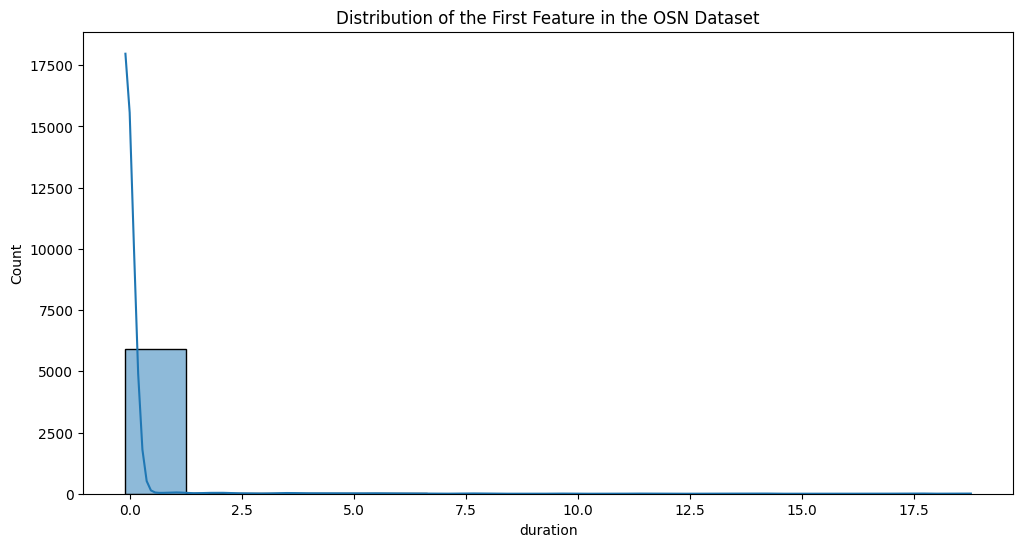

In [5]:
plt.figure(figsize=(12, 6))
sns.histplot(OSN_processed_features.iloc[:, 0], kde=True)
plt.title('Distribution of the First Feature in the OSN Dataset')
plt.show()

## 2. Feature Selection

In this section, we'll select the most important features from the preprocessed datasets. The feature selection pipeline consists of two main steps:

1.  **Feature Importance:** We use Recursive Feature Elimination (RFE) to select the most important features.
2.  **Dimensionality Reduction:** We reduce the dimensionality of the selected features using PCA or t-SNE.

In [6]:
def reduce_dimensionality(features, dataset_type):
    numeric_features = features.select_dtypes(include=np.number)
    non_numeric_features = features.select_dtypes(exclude=np.number)

    if numeric_features.empty:
        return features

    if dataset_type == "OSN" and numeric_features.shape[1] > 50:
        reducer = TSNE(n_components=2, perplexity=min(30, len(numeric_features)-1), random_state=42)
    else:
        reducer = PCA(n_components=2, random_state=42)

    reduced_numeric_data = reducer.fit_transform(numeric_features)
    reduced_df = pd.DataFrame(reduced_numeric_data, index=numeric_features.index)

    return pd.concat([reduced_df, non_numeric_features], axis=1)

def select_important_features(features, labels):
    numeric_features = features.select_dtypes(include=np.number)
    non_numeric_features = features.select_dtypes(exclude=np.number)

    if numeric_features.empty:
        return features

    estimator = RandomForestClassifier(random_state=42)
    n_features_to_select = min(5, numeric_features.shape[1])
    selector = RFE(estimator, n_features_to_select=n_features_to_select, step=1)
    selector = selector.fit(numeric_features, labels)

    selected_numeric_features = numeric_features.loc[:, selector.support_]

    return pd.concat([selected_numeric_features, non_numeric_features], axis=1)

def feature_selection(features, labels, dataset_type):
    if features is None or features.empty:
        print(f"Features for {dataset_type} is empty. Skipping feature selection.")
        return None

    X_important = select_important_features(features, labels)
    X_reduced = reduce_dimensionality(X_important, dataset_type)

    print(f"Feature selection complete for {dataset_type} dataset.")
    return X_reduced

In [7]:
OSN_features_selected = feature_selection(OSN_processed_features, OSN_processed_labels, "OSN")
Network_features_selected = feature_selection(Network_processed_features, Network_processed_labels, "Network")

print("OSN Features Head:")
print(OSN_features_selected.head())

print("Network Features Head:")
print(Network_features_selected.head())

/tmp/ipykernel_19534/3945626703.py:16: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  return pd.concat([reduced_df, non_numeric_features], axis=1)


Feature selection complete for OSN dataset.


Feature selection complete for Network dataset.
OSN Features Head:
          0         1
0  1.369276 -0.151174
1  1.064130 -0.145054
2 -1.613268  0.028845
3  0.537822 -0.078912
4  1.064130 -0.145054
Network Features Head:
          0         1
0  0.710412  0.091858
1  0.088392  0.707182
2 -0.896033 -0.002245
3  0.403322 -0.347035
4  0.088392  0.707182


/tmp/ipykernel_19534/3945626703.py:16: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  return pd.concat([reduced_df, non_numeric_features], axis=1)


## 3. Model Training

In [8]:
def train_deep_learning_model(features, labels, dataset_type):
    if features is None or labels is None or features.empty:
        print(f"Skipping deep learning model training for {dataset_type} due to missing data.")
        return None

    num_classes = len(np.unique(labels))
    model = Sequential([
        Input(shape=(features.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    X_train, X_val, y_train, y_val = train_test_split(features.values, labels.values, test_size=0.2, random_state=42)

    model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), verbose=1)
    return model

osn_dl_model = train_deep_learning_model(OSN_features_selected, OSN_processed_labels, "OSN")
network_dl_model = train_deep_learning_model(Network_features_selected, Network_processed_labels, "Network")

2025-11-17 20:22:26.818836: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/5


  1/150 ━━━━━━━━━━━━━━━━━━━━ 9:35 4s/step - accuracy: 0.8438 - loss: 0.6336

 12/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8841 - loss: 0.5627 

 23/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8843 - loss: 0.5423

 30/150 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8839 - loss: 0.5309

 42/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8829 - loss: 0.5147

 52/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8824 - loss: 0.5023

 64/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8821 - loss: 0.4893

 77/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8817 - loss: 0.4773

 87/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8817 - loss: 0.4687

 97/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8819 - loss: 0.4607

112/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8820 - loss: 0.4502

124/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8820 - loss: 0.4429

133/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8820 - loss: 0.4380

146/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8820 - loss: 0.4314

150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8821 - loss: 0.3623 - val_accuracy: 0.8875 - val_loss: 0.3249


Epoch 2/5


  1/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9688 - loss: 0.1865

 24/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9146 - loss: 0.2686 

 43/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9111 - loss: 0.2784

 54/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9091 - loss: 0.2825

 70/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9064 - loss: 0.2880

 86/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9049 - loss: 0.2909

101/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9041 - loss: 0.2925

119/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9031 - loss: 0.2943

137/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9024 - loss: 0.2956

150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8975 - loss: 0.3058 - val_accuracy: 0.8892 - val_loss: 0.3222


Epoch 3/5


  1/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9062 - loss: 0.2812

 24/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9018 - loss: 0.2780 

 49/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9017 - loss: 0.2832

 76/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9030 - loss: 0.2837

105/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9033 - loss: 0.2853

132/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9034 - loss: 0.2868

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8998 - loss: 0.3025 - val_accuracy: 0.8875 - val_loss: 0.3260


Epoch 4/5


  1/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9688 - loss: 0.1968

 27/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9132 - loss: 0.2721 

 49/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9037 - loss: 0.2886

 70/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9015 - loss: 0.2934

 93/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9004 - loss: 0.2954

112/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9000 - loss: 0.2961

135/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8998 - loss: 0.2964

150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8998 - loss: 0.2987 - val_accuracy: 0.8900 - val_loss: 0.3201


Epoch 5/5


  1/150 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.9375 - loss: 0.2393

 14/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8994 - loss: 0.3006 

 29/150 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8944 - loss: 0.3134

 45/150 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8960 - loss: 0.3128

 63/150 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8958 - loss: 0.3141

 75/150 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8960 - loss: 0.3141

 90/150 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8964 - loss: 0.3134

104/150 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8965 - loss: 0.3130

117/150 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8967 - loss: 0.3120

132/150 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8969 - loss: 0.3110

145/150 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8971 - loss: 0.3103

150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9002 - loss: 0.2992 - val_accuracy: 0.8875 - val_loss: 0.3262


Epoch 1/5


  1/126 ━━━━━━━━━━━━━━━━━━━━ 3:43 2s/step - accuracy: 0.5312 - loss: 0.6740

 20/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7738 - loss: 0.6303 

 39/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8155 - loss: 0.5954

 53/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8321 - loss: 0.5711

 66/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8420 - loss: 0.5508

 80/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8500 - loss: 0.5305

 99/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8582 - loss: 0.5061

115/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8635 - loss: 0.4888

126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8978 - loss: 0.3652 - val_accuracy: 0.8988 - val_loss: 0.2839


Epoch 2/5


  1/126 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9375 - loss: 0.1866

 17/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9143 - loss: 0.2578 

 29/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9107 - loss: 0.2634

 51/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9094 - loss: 0.2653

 70/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9081 - loss: 0.2669

 88/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9076 - loss: 0.2674

108/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9066 - loss: 0.2686

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9037 - loss: 0.2694 - val_accuracy: 0.9058 - val_loss: 0.2769


Epoch 3/5


  1/126 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9688 - loss: 0.1867

 23/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9185 - loss: 0.2477 

 36/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9164 - loss: 0.2505

 47/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9143 - loss: 0.2533

 60/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9116 - loss: 0.2564

 74/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9098 - loss: 0.2585

 88/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9087 - loss: 0.2600

100/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9083 - loss: 0.2608

115/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9081 - loss: 0.2610

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9065 - loss: 0.2642 - val_accuracy: 0.9038 - val_loss: 0.2739


Epoch 4/5


  1/126 ━━━━━━━━━━━━━━━━━━━━ 1:09 553ms/step - accuracy: 0.9688 - loss: 0.1425

 15/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9013 - loss: 0.2723    

 29/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9073 - loss: 0.2616

 39/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9094 - loss: 0.2575

 54/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9095 - loss: 0.2573

 69/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9089 - loss: 0.2585

 80/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9081 - loss: 0.2597

 95/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9075 - loss: 0.2609

104/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9074 - loss: 0.2611

113/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9075 - loss: 0.2611

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9074 - loss: 0.2620 - val_accuracy: 0.9018 - val_loss: 0.2746


Epoch 5/5


  1/126 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8750 - loss: 0.2677

 17/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8955 - loss: 0.2730 

 31/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9017 - loss: 0.2654

 46/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9051 - loss: 0.2609

 62/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9079 - loss: 0.2572

 78/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9088 - loss: 0.2566

 95/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9096 - loss: 0.2560

109/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9097 - loss: 0.2562

125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9097 - loss: 0.2565

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9084 - loss: 0.2613 - val_accuracy: 0.9018 - val_loss: 0.2736


## 4. Explainable AI

1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/home/winner/.local/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 2))']
  warnings.warn(msg)
/home/winner/.local/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 2))']
  warnings.warn(msg)


OSN LRP Values Head:
          0         1
0  0.521210  0.029733
1  0.458542  0.031984
2  1.224053  0.001281
3  0.278061  0.014427
4  0.458542  0.031984


/tmp/ipykernel_19534/2971544294.py:58: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(osn_shap, shap_data)
/home/winner/.local/lib/python3.10/site-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/home/winner/.local/lib/python3.10/site-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


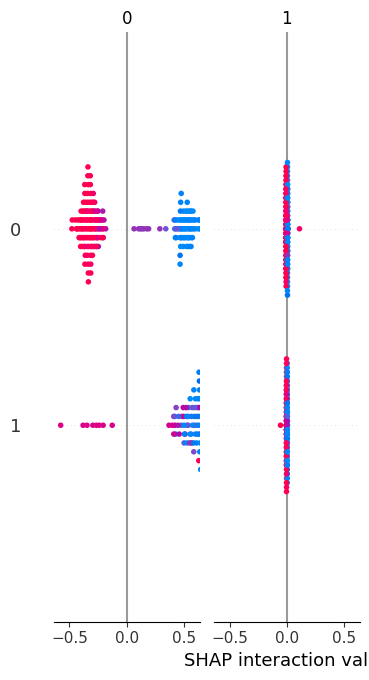

In [9]:
def lrp_rule(layer, R, a):
    weights = layer.get_weights()
    if not weights:
        return R
    w = weights[0]
    b = weights[1] if len(weights) > 1 else 0
    epsilon = 1e-7
    z = np.dot(a, w) + b
    s = R / (z + epsilon)
    c = np.dot(s, w.T)
    return a * c

def _to_numpy(value):
    if hasattr(value, "numpy"):
        return value.numpy()
    return np.array(value)

def lrp_explain(model, data):
    activation_inputs = []
    current = data
    for layer in model.layers:
        activation_inputs.append(_to_numpy(current))
        current = layer(current)

    R = model.predict(data)
    for i in range(len(model.layers) - 1, -1, -1):
        layer = model.layers[i]
        if not layer.get_weights():
            continue
        R = lrp_rule(layer, R, activation_inputs[i])
    return R

def shap_explain(model, data, model_type='deep_learning'):
    if model_type == 'deep_learning':
        explainer = shap.GradientExplainer(model, data)
    elif model_type == 'tree':
        explainer = shap.TreeExplainer(model, data)
    else:
        explainer = shap.KernelExplainer(model.predict, data)

    shap_values = explainer.shap_values(data)

    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    return shap_values

shap_sample_size = min(200, OSN_features_selected.shape[0])
shap_data = OSN_features_selected.iloc[:shap_sample_size]
shap_data = shap_data.rename(columns=lambda col: str(col))

osn_lrp = lrp_explain(osn_dl_model, shap_data.values)
osn_shap = shap_explain(osn_dl_model, shap_data.values, 'deep_learning')

print("OSN LRP Values Head:")
print(pd.DataFrame(osn_lrp, columns=shap_data.columns).head())

shap.summary_plot(osn_shap, shap_data)


## 5. Conclusion